# Import required modules

In [22]:
import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)

import scanpy as sc
import anndata
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import matplotlib as mpl
import seaborn as sns
import os 
from mpl_toolkits.axes_grid1 import make_axes_locatable

import celltypist
from celltypist import models

import scipy
import scanpy.external as sce
from fastprogress.fastprogress import progress_bar

In [2]:
import session_info
session_info.show()

In [3]:
import importlib.util
import sys
spec = importlib.util.spec_from_file_location("module.name", "/nfs/team205/kk18/function/python/utils.py")
utils = importlib.util.module_from_spec(spec)
sys.modules["module.name"] = utils
spec.loader.exec_module(utils)

In [4]:
sc.settings.verbosity = 1          # verbosity: errors (0), warnings (1), info (2), hints (3)
sc.settings.set_figure_params(dpi=80)

# Prepare functions

# Read in anndata

In [8]:
adata = sc.read_h5ad('/lustre/scratch126/cellgen/team205/kk18/datasets/YS/ys_portal_object_20221208.h5ad')
adata

AnnData object with n_obs × n_vars = 169494 × 37318
    obs: 'component', 'stage', 'sex', 'sort.ids', 'fetal.ids', 'orig.dataset', 'sequencing.type', 'lanes', 'LVL1', 'LVL2', 'LVL3'
    obsm: 'X_umap'

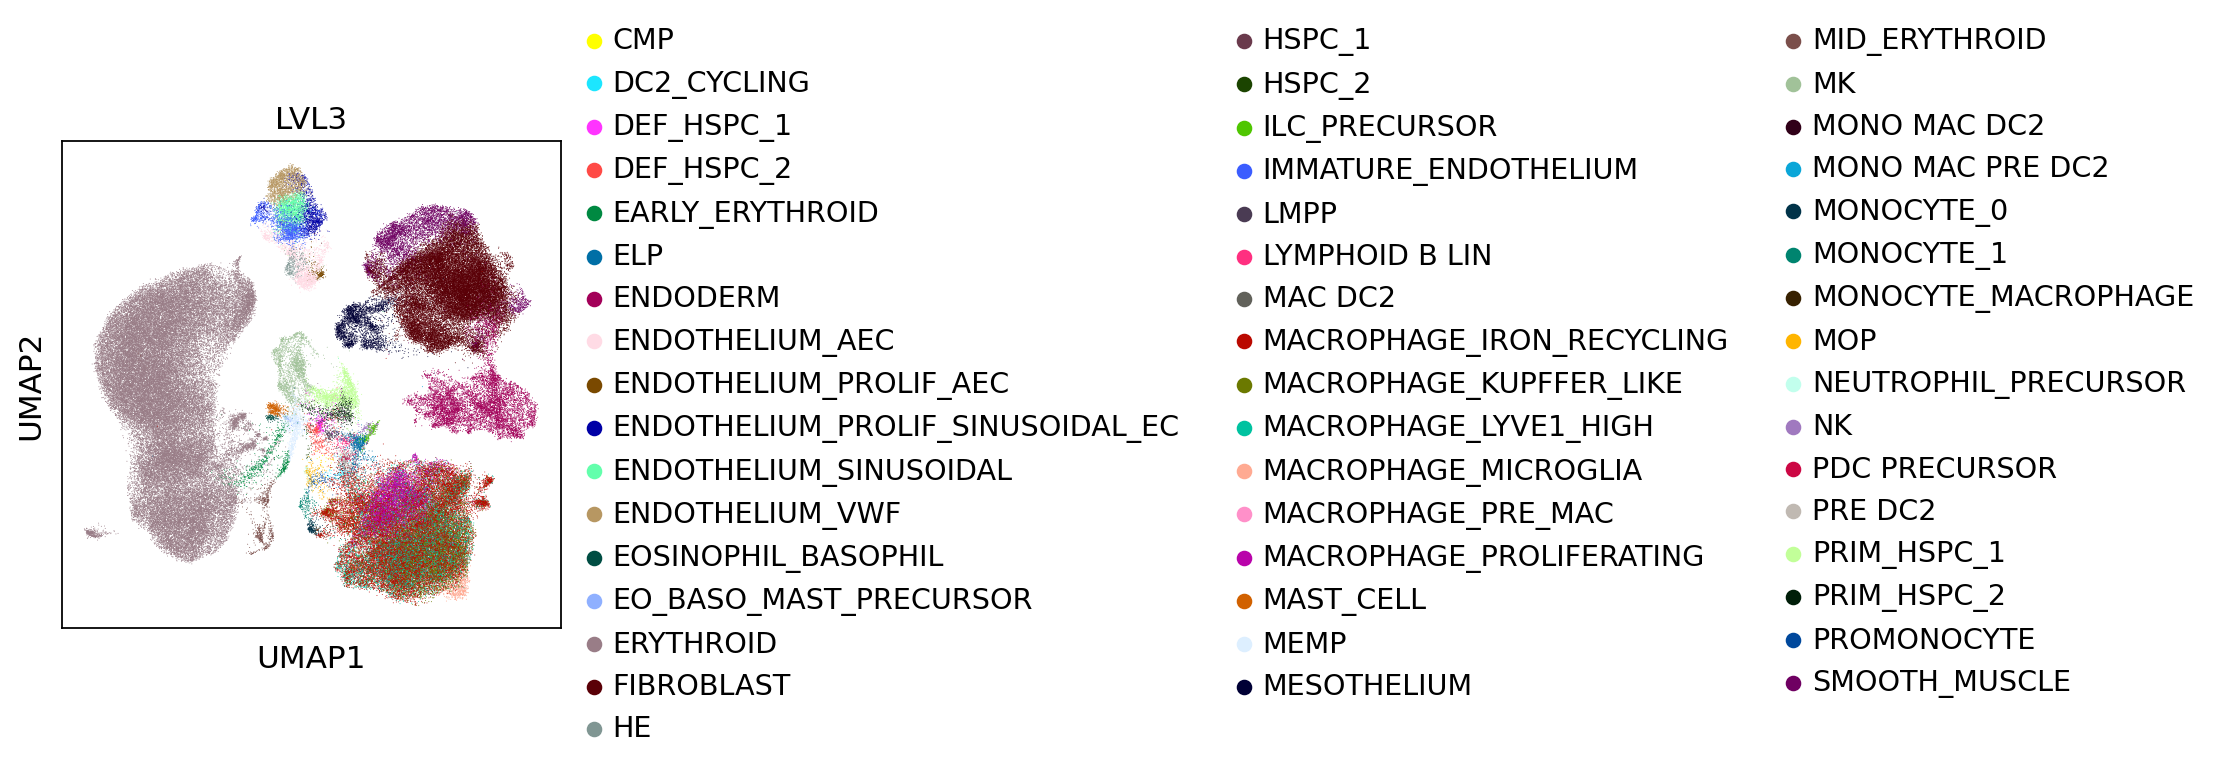

In [9]:
sc.pl.umap(adata, color='LVL3')

In [10]:
adata.X.data[:5]

array([0.94222367, 0.94222367, 0.94222367, 0.94222367, 0.94222367],
      dtype=float32)

In [11]:
set(adata.obs['LVL3'])

{'CMP',
 'DC2_CYCLING',
 'DEF_HSPC_1',
 'DEF_HSPC_2',
 'EARLY_ERYTHROID',
 'ELP',
 'ENDODERM',
 'ENDOTHELIUM_AEC',
 'ENDOTHELIUM_PROLIF_AEC',
 'ENDOTHELIUM_PROLIF_SINUSOIDAL_EC',
 'ENDOTHELIUM_SINUSOIDAL',
 'ENDOTHELIUM_VWF',
 'EOSINOPHIL_BASOPHIL',
 'EO_BASO_MAST_PRECURSOR',
 'ERYTHROID',
 'FIBROBLAST',
 'HE',
 'HSPC_1',
 'HSPC_2',
 'ILC_PRECURSOR',
 'IMMATURE_ENDOTHELIUM',
 'LMPP',
 'LYMPHOID B LIN',
 'MAC DC2',
 'MACROPHAGE_IRON_RECYCLING',
 'MACROPHAGE_KUPFFER_LIKE',
 'MACROPHAGE_LYVE1_HIGH',
 'MACROPHAGE_MICROGLIA',
 'MACROPHAGE_PRE_MAC',
 'MACROPHAGE_PROLIFERATING',
 'MAST_CELL',
 'MEMP',
 'MESOTHELIUM',
 'MID_ERYTHROID',
 'MK',
 'MONO MAC DC2',
 'MONO MAC PRE DC2',
 'MONOCYTE_0',
 'MONOCYTE_1',
 'MONOCYTE_MACROPHAGE',
 'MOP',
 'NEUTROPHIL_PRECURSOR',
 'NK',
 'PDC PRECURSOR',
 'PRE DC2',
 'PRIM_HSPC_1',
 'PRIM_HSPC_2',
 'PROMONOCYTE',
 'SMOOTH_MUSCLE'}

In [12]:
set(adata.obs['fetal.ids'])

{'F138',
 'F32',
 'F35',
 'F37',
 'F61',
 'F79',
 'F80',
 'Wang_CS10',
 'Wang_CS11',
 'mikola_1'}

# Subset macrophages

In [14]:
cells_to_select = ['MACROPHAGE_IRON_RECYCLING',
 'MACROPHAGE_KUPFFER_LIKE',
 'MACROPHAGE_LYVE1_HIGH',
 'MACROPHAGE_MICROGLIA',
 'MACROPHAGE_PRE_MAC']
# excluding proliferating cells

adata = adata[adata.obs['LVL3'].isin(cells_to_select)]
adata.obs['LVL3'].value_counts()

MACROPHAGE_IRON_RECYCLING    22946
MACROPHAGE_LYVE1_HIGH         8385
MACROPHAGE_KUPFFER_LIKE       7724
MACROPHAGE_MICROGLIA           613
MACROPHAGE_PRE_MAC              29
Name: LVL3, dtype: int64

In [15]:
# filter genes
sc.pp.filter_genes(adata, min_cells=3)

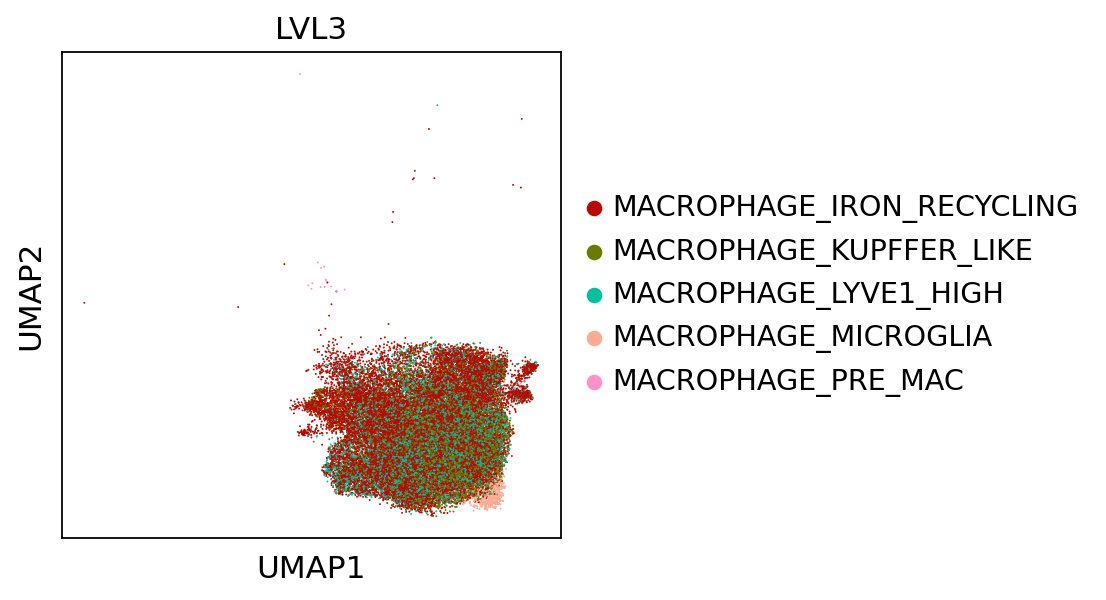

In [16]:
sc.pl.umap(adata, color='LVL3')

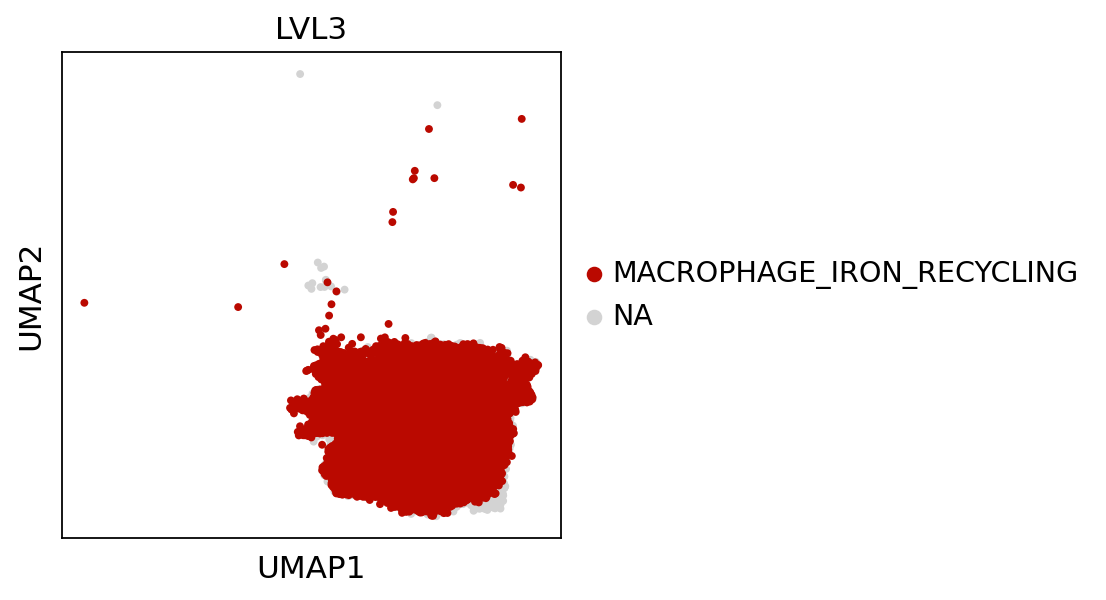

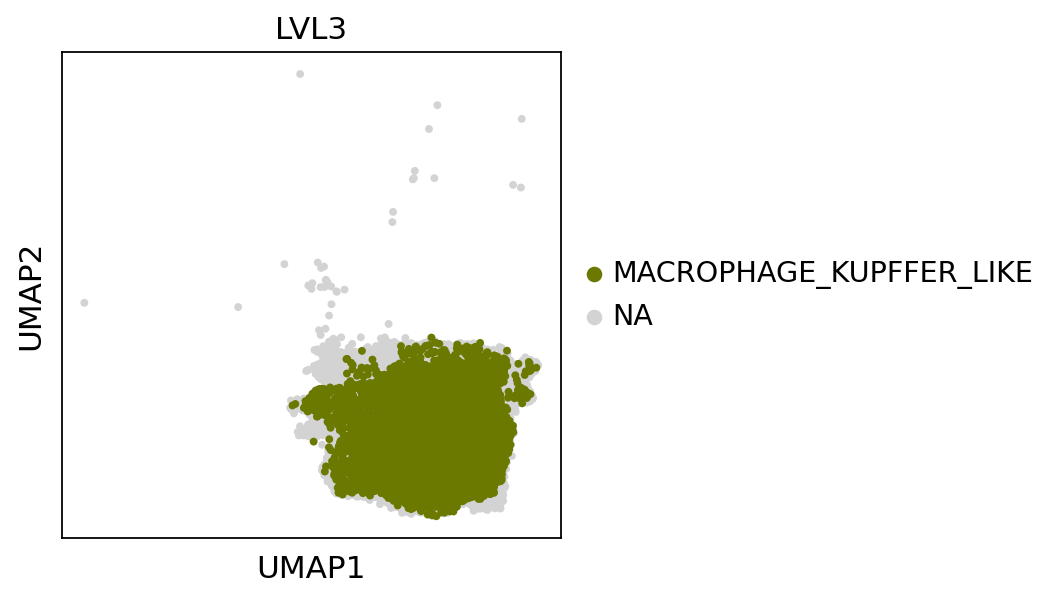

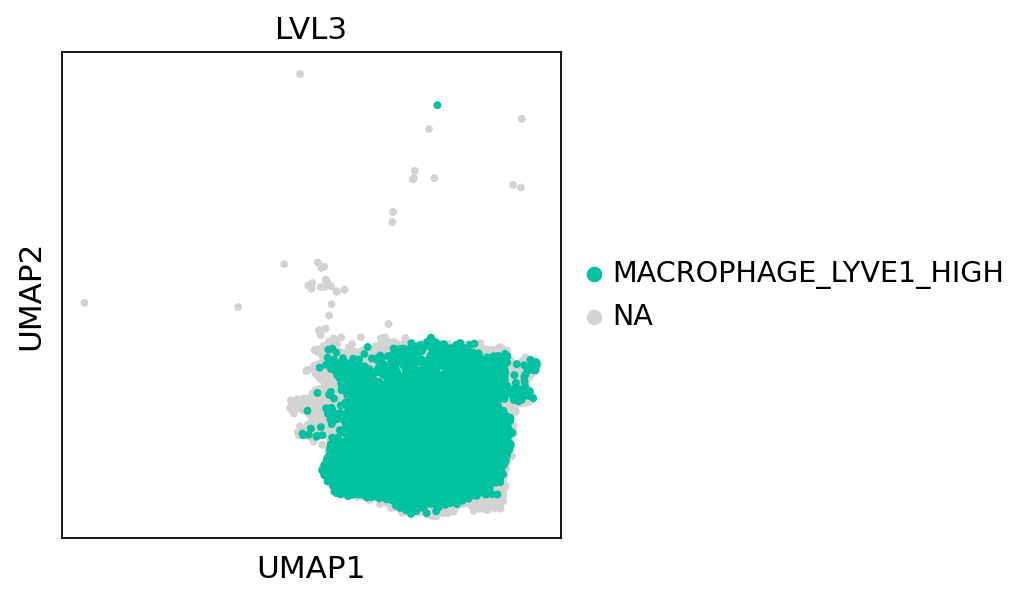

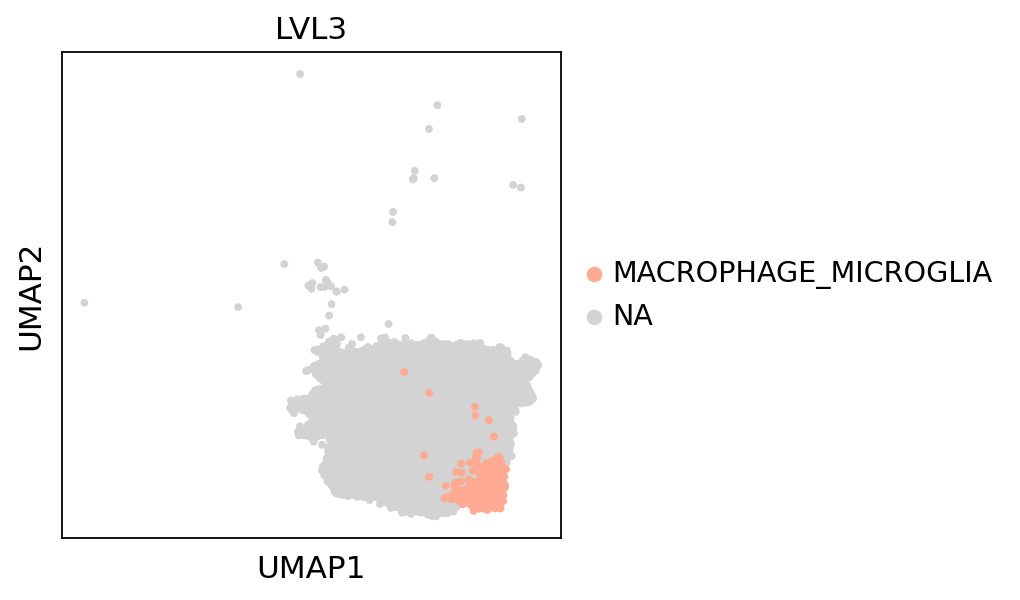

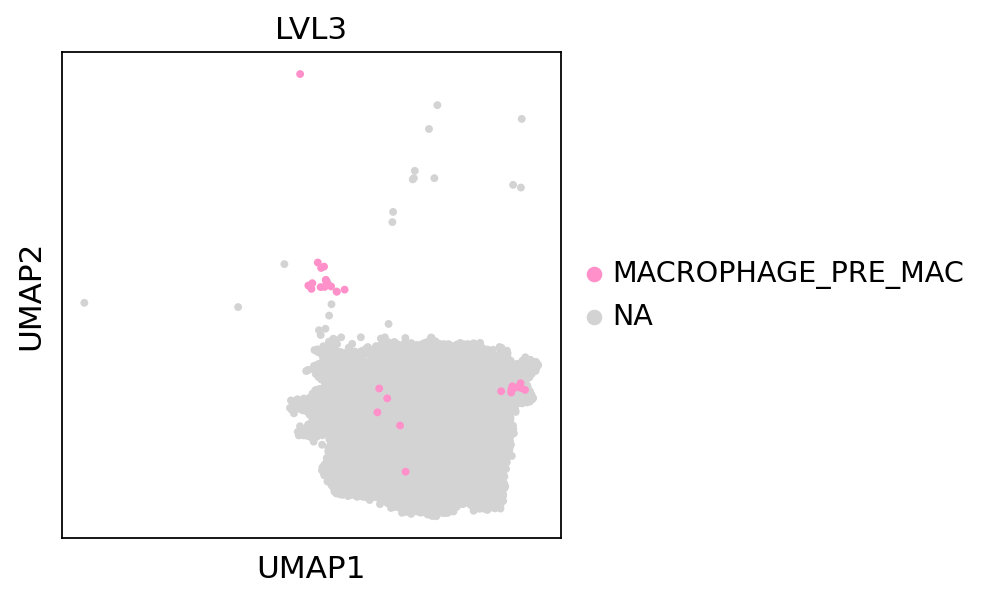

In [17]:
for celltype in cells_to_select:
    sc.pl.umap(adata, color='LVL3', groups=celltype, size=50)

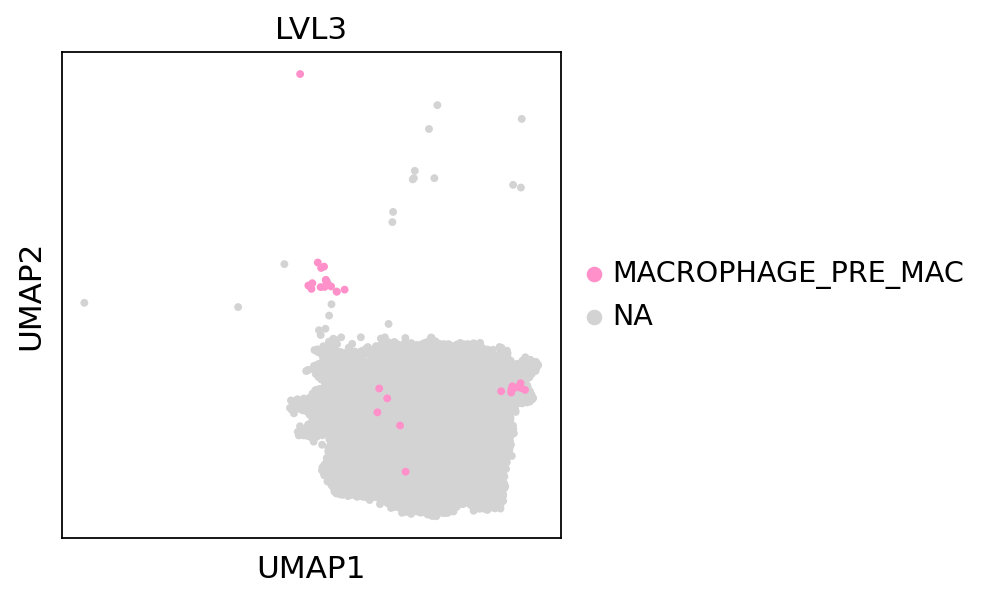

In [18]:
sc.pl.umap(adata, color='LVL3', groups='MACROPHAGE_PRE_MAC', size=50)

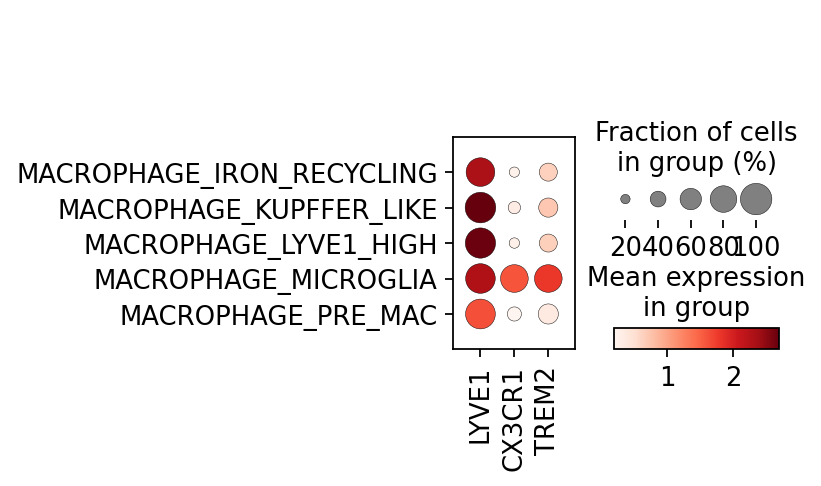

In [19]:
sc.pl.dotplot(adata,var_names=['LYVE1','CX3CR1','TREM2'],groupby='LVL3')

# Merge non-pre, non-microglia populations

* based on Goh et al, Science, 2023
* Sup Fig.8C

In [20]:
adata.obs['LVL3_mod'] = adata.obs['LVL3'].copy()
adata.obs.replace({'LVL3_mod':{
    'MACROPHAGE_IRON_RECYCLING':'MACROPHAGE',
 'MACROPHAGE_KUPFFER_LIKE':'MACROPHAGE',
 'MACROPHAGE_LYVE1_HIGH':'MACROPHAGE',
 # 'MACROPHAGE_MICROGLIA':'MACROPHAGE_MICROGLIA',
 # 'MACROPHAGE_PRE_MAC':'MACROPHAGE_PRE_MAC'
}}, inplace=True)
adata.obs['LVL3_mod'].value_counts()

MACROPHAGE              39055
MACROPHAGE_MICROGLIA      613
MACROPHAGE_PRE_MAC         29
Name: LVL3_mod, dtype: int64

In [21]:
adata

AnnData object with n_obs × n_vars = 39697 × 28532
    obs: 'component', 'stage', 'sex', 'sort.ids', 'fetal.ids', 'orig.dataset', 'sequencing.type', 'lanes', 'LVL1', 'LVL2', 'LVL3', 'LVL3_mod'
    var: 'n_cells'
    uns: 'LVL3_colors'
    obsm: 'X_umap'

# Get informative genes

## HVGs

* subsample and perform HVG detection
* do 100 iteration (subsampling part) and select genes which was reproducible 10 times out of 100 

In [80]:
groupby = 'LVL3_mod'
max_n = 30
n_iteration = 100
n_detected = 30
batch_key = 'fetal.ids'

In [25]:
# iteration
res = {}
for i in progress_bar(range(n_iteration)):
    # subsample
    adata_sub = utils.sctk_subsample(adata, fraction=1, groupby=groupby, max_n=max_n, random_state=i)
    # remove donors those cell number is 1
    vals = adata_sub.obs[batch_key].value_counts()
    samples_to_remove = list(vals.index[vals==1])
    adata_sub = adata_sub[adata_sub.obs[batch_key].isin(samples_to_remove)==False]
    # hvg detection
    sc.pp.highly_variable_genes(adata_sub, min_mean=0.0125, max_mean=3, min_disp=0.5, batch_key=batch_key)
    # print(f'n_hvg: {sum(adata_sub.var.highly_variable)}')
    # store data
    res[i] = adata_sub.var.highly_variable
    del adata_sub

# plot
l = []
for i in range(n_iteration):
    l.append(len(res_df.index[res_df.sum(axis=1)>i]))
plt.scatter(x=range(n_iteration), y=l)

final seleted hvgs: 3089


In [81]:
# selection
res_df = pd.DataFrame(res)
hvgs = list(res_df.index[res_df.sum(axis=1)>=n_detected])
print(f'final seleted hvgs: {len(hvgs)}')

final seleted hvgs: 868


# Training CellTypist model

## Select cells to train

In [43]:
from geosketch import gs

Signature: gs(X, N, **kwargs)
Docstring:
Geometric sketching.
Wrapper around `gs_gap()`, see parameter documentation in that
function.
File:      ~/my-conda-envs/vitro/lib/python3.8/site-packages/geosketch/sketch.py
Type:      function

In [75]:
groups_to_subset = ['MACROPHAGE','MACROPHAGE_MICROGLIA']
max_n = 30
batch_key = 'fetal.ids'

adata.obs['select'] = True
adata.obs['geosketch_index'] = False
for grp in groups_to_subset:
    print(f'##### {grp} #####')
    # subset
    adata_sub = adata[adata.obs['LVL3_mod']==grp]
    # remove samples those cell number is 1
    vals = adata_sub.obs[batch_key].value_counts()
    samples_to_remove = list(vals.index[vals==1])
    obsnames_to_remove = adata_sub.obs_names[adata_sub.obs[batch_key].isin(samples_to_remove)]
    adata_sub = adata_sub[adata_sub.obs[batch_key].isin(samples_to_remove)==False]
    # hvg detection
    sc.pp.highly_variable_genes(adata_sub, min_mean=0.0125, max_mean=3, min_disp=0.5, 
                                batch_key=batch_key, subset=True)
    print(f'n_hvg: {adata_sub.shape[1]}')
    print(f'n_cell: {adata_sub.shape[0]}')
    # scale, pca
    print('pca, batch correction')
    sc.pp.scale(adata_sub, max_value=10)
    sc.tl.pca(adata_sub, svd_solver='arpack')
    # harmony for batch correction
    sce.pp.harmony_integrate(adata_sub, key=batch_key, max_iter_harmony=30)
    # geosketch
    print('geosketching')
    sketch_index = gs(adata_sub.obsm['X_pca_harmony'], max_n, replace=False)
    # store to adata
    obsnames = adata_sub.obs_names[sketch_index]
    obsnames_others = adata_sub.obs_names[[x for x in range(len(adata_sub.obs_names)) if x not in sketch_index]]
    adata.obs.loc[obsnames_to_remove,'select'] = False # removed cells before hvg detection
    adata.obs.loc[obsnames_others,'select'] = False
    adata.obs.loc[obsnames,'geosketch_index'] = True
    print('')

##### MACROPHAGE #####
n_hvg: 1280
n_cell: 39055
pca, batch correction


2023-11-18 11:56:57,958 - harmonypy - INFO - Computing initial centroids with sklearn.KMeans...
Computing initial centroids with sklearn.KMeans...
2023-11-18 11:57:31,447 - harmonypy - INFO - sklearn.KMeans initialization complete.
sklearn.KMeans initialization complete.
2023-11-18 11:57:31,865 - harmonypy - INFO - Iteration 1 of 30
Iteration 1 of 30
2023-11-18 11:58:02,145 - harmonypy - INFO - Iteration 2 of 30
Iteration 2 of 30
2023-11-18 11:58:32,740 - harmonypy - INFO - Converged after 2 iterations
Converged after 2 iterations


geosketching

##### MACROPHAGE_MICROGLIA #####
n_hvg: 904
n_cell: 612
pca, batch correction


2023-11-18 11:58:43,743 - harmonypy - INFO - Computing initial centroids with sklearn.KMeans...
Computing initial centroids with sklearn.KMeans...
2023-11-18 11:58:44,653 - harmonypy - INFO - sklearn.KMeans initialization complete.
sklearn.KMeans initialization complete.
2023-11-18 11:58:44,721 - harmonypy - INFO - Iteration 1 of 30
Iteration 1 of 30
2023-11-18 11:58:45,055 - harmonypy - INFO - Iteration 2 of 30
Iteration 2 of 30
2023-11-18 11:58:45,368 - harmonypy - INFO - Iteration 3 of 30
Iteration 3 of 30
2023-11-18 11:58:45,566 - harmonypy - INFO - Iteration 4 of 30
Iteration 4 of 30
2023-11-18 11:58:45,761 - harmonypy - INFO - Iteration 5 of 30
Iteration 5 of 30
2023-11-18 11:58:45,954 - harmonypy - INFO - Iteration 6 of 30
Iteration 6 of 30
2023-11-18 11:58:46,057 - harmonypy - INFO - Iteration 7 of 30
Iteration 7 of 30
2023-11-18 11:58:46,326 - harmonypy - INFO - Iteration 8 of 30
Iteration 8 of 30
2023-11-18 11:58:46,356 - harmonypy - INFO - Iteration 9 of 30
Iteration 9 of 30

geosketching



In [76]:
pd.crosstab(adata.obs['select'],adata.obs['geosketch_index'])

geosketch_index,False,True
select,,
False,39608,0
True,29,60


In [77]:
# select
adata_sel = adata[adata.obs['select']]
adata_sel.obs['LVL3_mod'].value_counts()

MACROPHAGE              30
MACROPHAGE_MICROGLIA    30
MACROPHAGE_PRE_MAC      29
Name: LVL3_mod, dtype: int64

In [ ]:
'''
# subset
max_n = 30
adata_sub = utils.sctk_subsample(adata, fraction=1, groupby=groupby, max_n=max_n, random_state=0)
adata_sub.obs[groupby].value_counts()
'''

## Train

In [82]:
%%time
model = celltypist.train(adata_sel[:,hvgs],  # selecting defined hvgs
                         labels = groupby,
                         n_jobs = 10,
                         feature_selection = False, # since manually selected
                         check_expression = False
                        )

# Save the model
model.write('/nfs/team205/heart/anndata_objects/Foetal/celltypist/model_YS_portal_object_20221208_onlyMP_hvg_18Nov2023.pkl')

🍳 Preparing data before training
🔬 Input data has 89 cells and 868 genes
⚖️ Scaling input data
🏋️ Training data using logistic regression
✅ Model training done!


CPU times: user 23.7 ms, sys: 8.92 ms, total: 32.6 ms
Wall time: 63.1 ms


In [83]:
%%time
# train with all genes
model = celltypist.train(adata_sel,  # all genes
                         labels = groupby,
                         n_jobs = 10,
                         feature_selection = False, # since manually selected
                         check_expression = False
                        )

# Save the model
model.write('/nfs/team205/heart/anndata_objects/Foetal/celltypist/model_YS_portal_object_20221208_onlyMP_allgenes_18Nov2023.pkl')

🍳 Preparing data before training
✂️ 11196 non-expressed genes are filtered out
🔬 Input data has 89 cells and 17336 genes
⚖️ Scaling input data
🏋️ Training data using logistic regression
✅ Model training done!


CPU times: user 55.9 ms, sys: 11.7 ms, total: 67.6 ms
Wall time: 697 ms
